# MMC - Laboratorium 4 - Bartosz Sosik (310287)

## Zadanie 3

Analityczne rozwiązanie całki $\int_0^{\frac{\pi}{2}} sin(x) dx = (-cos(x))|_0^{\frac{\pi}{2}} = 1$

### Obliczenie wartości całki metodą podstawową monte Carlo

In [203]:
import numpy as np
import math

# Funkcja podcałkowa
def f(x):
    return np.sin(x)

# Metoda podstawowa
def mc_int_basic(fun, a, b, n=1000):
    # Wylosowanie n liczb z rozkładu równomiernego na przedziale a,b
    vals = np.random.uniform(a, b, n)
    # Wartości funkcji podcałkowej w wylosowanych punktach
    y = [fun(val) for val in vals]
    y_mean = np.sum(y)/n
    integral = (b-a)*y_mean

    # Błąd
    error = abs(integral-1)

    # Odchylenie standardowe
    y_square = np.square(y)
    std = (1/(np.sqrt(n*(n-1))))*np.sqrt(np.sum(y_square)-(1/n)*np.square(np.sum(y)))
    std = (b-a)*std
    unc = 2*std
    return integral, error, unc

In [204]:
# Przykładowy wynik
mc_int_basic(f, 0, math.pi/2, n=1000)

(0.9959574133012085, 0.004042586698791539, 0.030773768393648076)

### Obliczenie całki MC z zamianą zmiennych
Dokonujemy podstawienia $x = g(z) = \sqrt{z}$. \
Zmieniamy granicę całkowania na: $z_{min} = g^{-1}(a)$ oraz $z_{max} = g^{-1}(b)$. \
Funkcja odwrotna $g^{-1}(z)=z^2$ \
Następnie należy scałkować metodą podstawową wyrażenie $f(g(z))\frac{dg}{dz}$ przy zmienionych granicach.
Nowe wyrażenie podcałkowe wynosi zatem: $sin(\sqrt{z})/(2*\sqrt{z})$

In [205]:
def mc_int_swap(fun, a, b, n=10000):
    
    # Zamiana granic całkowania
    z_min = a**2
    z_max = b**2

    # Liczby z rozkładu równomiernego na przedziale z_min z_max
    vals = np.random.uniform(z_min, z_max, n)
    # Wartości funkcji podcałkowej w wylosowanych punktach
    y = fun(np.sqrt(vals))/(2*np.sqrt(vals))
    y_mean = np.sum(y)/n
    integral = y_mean*(z_max-z_min)

    # Błąd
    error = abs(integral-1)

    # Odchylenie standardowe
    y_square = np.square(y)

    std = (1/(np.sqrt(n*(n-1))))*np.sqrt(np.sum(y_square)-(1/n)*np.square(np.sum(y)))
    std = (z_max-z_min)*std
    unc = 2*std
    return integral, error, unc

In [206]:
# Przykładowy wynik
mc_int_swap(f, 0, math.pi/2, n=1000)

(0.9995360805464846, 0.00046391945351542674, 0.008270988653159792)

In [207]:
n_count = 100
count_list = list()

int_normal_list = list()
error_normal_list = list()
unc_normal_list = list()
int_swap_list = list()
error_swap_list = list()
unc_swap_list = list()


while n_count < 10000:
    int_normal, error_normal, unc_normal = mc_int_basic(f, 0, math.pi/2, n=n_count)
    int_swap, error_swap, unc_swap = mc_int_swap(f, 0, math.pi/2, n=n_count)

    int_normal_list.append(int_normal)
    error_normal_list.append(error_normal)
    unc_normal_list.append(unc_normal)

    int_swap_list.append(int_swap)
    error_swap_list.append(error_swap)
    unc_swap_list.append(unc_swap)

    count_list.append(n_count)

    n_count += 10

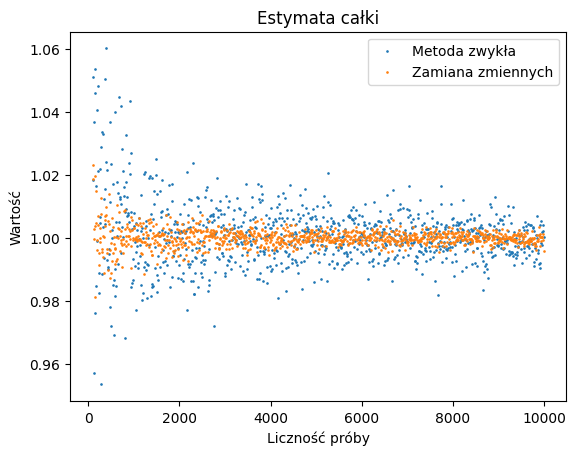

In [208]:
from matplotlib import pyplot as plt
plt.scatter(count_list, int_normal_list, label="Metoda zwykła", s=0.8)
plt.scatter(count_list, int_swap_list, label="Zamiana zmiennych", s=0.8)
plt.xlabel('Liczność próby')
plt.ylabel('Wartość')
plt.title("Estymata całki")
plt.legend(loc="best")


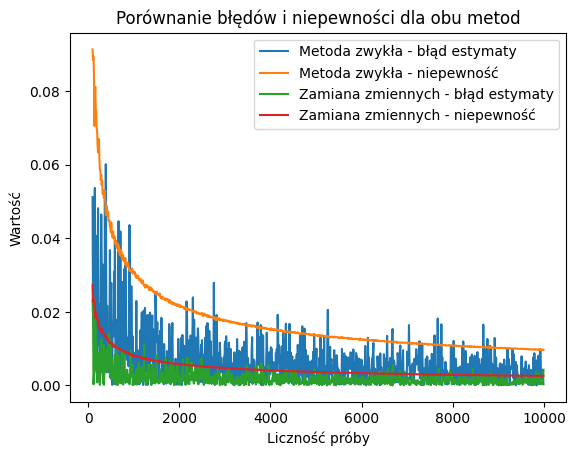

In [209]:
from matplotlib import pyplot as plt
plt.plot(count_list, error_normal_list, label="Metoda zwykła - błąd estymaty")
plt.plot(count_list, unc_normal_list, label="Metoda zwykła - niepewność")
plt.plot(count_list, error_swap_list, label="Zamiana zmiennych - błąd estymaty")
plt.plot(count_list, unc_swap_list, label="Zamiana zmiennych - niepewność")
plt.xlabel('Liczność próby')
plt.ylabel('Wartość')
plt.title("Porównanie błędów i niepewności dla obu metod")
plt.legend(loc="best")

Możemy zobaczyć, że zamiana zmiennych przyniosła zdecydowaną poprawę w jakości estymowania wartości całki. Na wykresie przedstawiającym estymatę w zależności od liczności próby możemy wizualnie zobaczyć, że wartości zwracane przez metodę z zamianą zmiennych są znacznie mniej rozproszone i skupiają się w okolicy prawdziewej wartości 1 znacznie bardziej niż wyniki z metody podstawowej. \
Istotnie zmalały także wartości błędów oraz niepewności, co zaprezentowane zostało na drugim wykresie. 

## Zadanie 7

Analityczne rozwiązanie całki $\int_0^{\pi} sin(x) dx = (-cos(x))|_0^{\pi} = 2$

### Oszacowanie wartości całki za pomocą metody orzeł-reszka

Generujemy punkty w przestrzeni dwuwymiarowej. Obie współrzędne punktu generowane są z rozkładu równomiernego z odpowiednich przedziałów. Przez $N$ oznaczamy liczbę wszystkich eksperymentów. $M$ będzie natomiast liczbą eksperymentów, które zakończyły się zaobserwowaniem wartości zmiennej losowej pod wykresem funkcji podcałkowej (oczywiście ograniczonym osiami współrzędnych). Za przybliżoną wartość całki przyjmuje się wówczas $I=M/N * (b-a)$, gdzie $a$ oraz $b$ to granice całkowania. Drugi czynnik odpowiedzialny jest za "przeskalowanie" uzyskanej wartości do faktycznych granic całkowania.

In [5]:
import random
from matplotlib import pyplot as plt
from scipy.stats import qmc
import math
import numpy as np

# Funkcja podcałkowa
def fun_sin(x):
    return math.sin(x)

# Ciąg Sobola - liczby Quasilosowe
quasi_gen = qmc.Sobol(d=2, scramble=False, seed=3)

def mc_int_hit_miss(fun, a, b, quasi_gen, n=10000, quasi=False):
    hits = 0
    # Przeskalowanie wyjscia z generatora Sobola
    l_bounds = [a, 0.0]
    u_bounds = [b, 1.0]
    for _ in range(n):
        if quasi is True:
            x, y = qmc.scale(quasi_gen.random(1), l_bounds, u_bounds)[0]
        else:
            x = random.uniform(a, b)
            y = random.uniform(0, 1)
        if y <= fun(x):
            hits += 1
    # Estymata wartości całki
    estimated_int = (hits/n) * (b-a)
    # Błąd
    error = abs(estimated_int - 2)
    return estimated_int, error

Zarówno dla liczb pseudolosowych, jak i quasilosowych wykonano 50 eksperymentów polegających na oszacowaniu wartości całki. Poniżej przedstawione zostały wartości uzyskanych błędów w kolejnych eksperymentach wraz z wartością średnią.

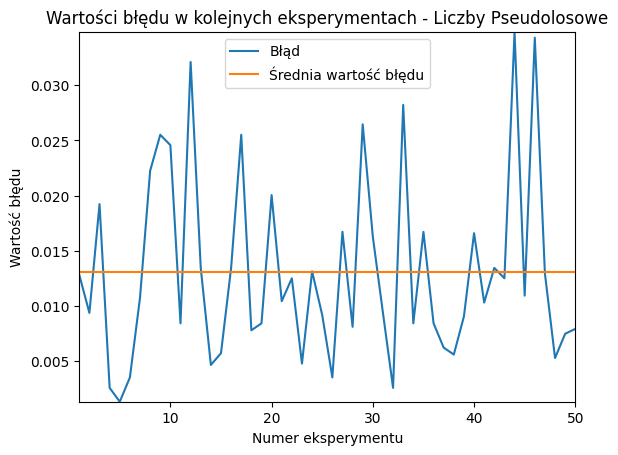

In [12]:
num_experiments_pseudo = 50
error_list_pseudo = list()
for _ in range(num_experiments_pseudo):
    est, error = mc_int_hit_miss(fun_sin, 0, math.pi, quasi_gen)
    error_list_pseudo.append(error)

plt.title('Wartości błędu w kolejnych eksperymentach - Liczby Pseudolosowe')
plt.xlabel('Numer eksperymentu')
plt.ylabel('Wartość błędu')
plt.ylim(min(error_list_pseudo), max(error_list_pseudo))
plt.xlim(1, num_experiments_pseudo)
plt.plot(np.linspace(1, num_experiments_pseudo, num_experiments_pseudo), error_list_pseudo, label="Błąd")
plt.plot(np.linspace(1, num_experiments_pseudo, num_experiments_pseudo), np.linspace(1, 1, num_experiments_pseudo)*sum(error_list_pseudo)/num_experiments_pseudo, label="Średnia wartość błędu")
plt.legend(loc="best")

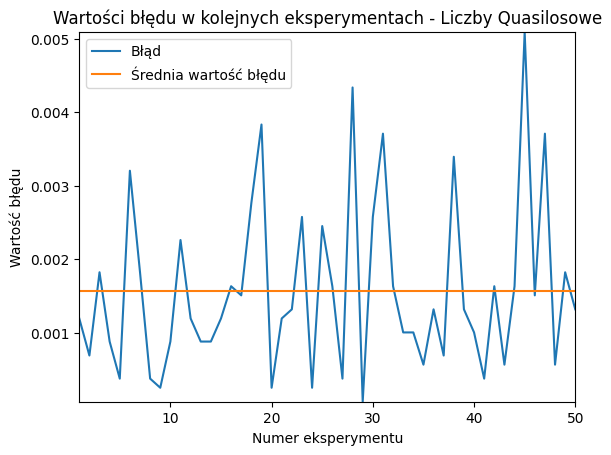

In [13]:
num_experiments_quasi = 50
error_list_quasi = list()
for _ in range(num_experiments_quasi):
    est, error = mc_int_hit_miss(fun_sin, 0, math.pi, quasi_gen, quasi=True)
    error_list_quasi.append(error)

plt.title('Wartości błędu w kolejnych eksperymentach - Liczby Quasilosowe')
plt.xlabel('Numer eksperymentu')
plt.ylabel('Wartość błędu')
plt.xlim(1, num_experiments_quasi)
plt.ylim(min(error_list_quasi), max(error_list_quasi))
plt.plot(np.linspace(1, num_experiments_quasi, num_experiments_quasi), error_list_quasi, label="Błąd")
plt.plot(np.linspace(1, num_experiments_quasi, num_experiments_quasi), np.linspace(1, 1, num_experiments_quasi)*sum(error_list_quasi)/num_experiments_quasi, label="Średnia wartość błędu")
plt.legend(loc="best")

### Porównanie otrzymanych wartości błędów

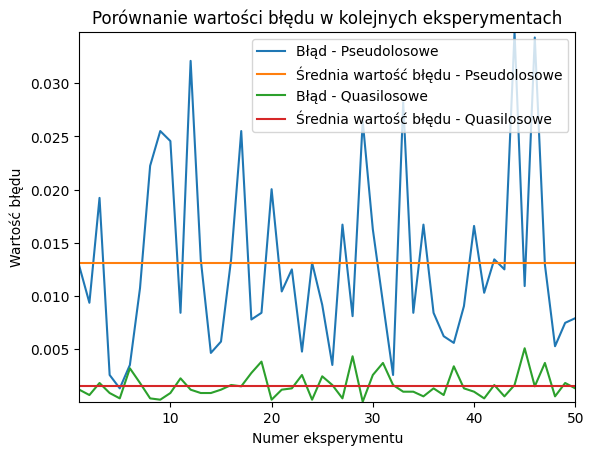

In [16]:
plt.title('Porównanie wartości błędu w kolejnych eksperymentach')
plt.xlabel('Numer eksperymentu')
plt.ylabel('Wartość błędu')
plt.xlim(1, num_experiments_quasi)
plt.ylim(min(error_list_quasi + error_list_pseudo), max(error_list_quasi + error_list_pseudo))
plt.plot(np.linspace(1, num_experiments_pseudo, num_experiments_pseudo), error_list_pseudo, label="Błąd - Pseudolosowe")
plt.plot(np.linspace(1, num_experiments_pseudo, num_experiments_pseudo), np.linspace(1, 1, num_experiments_pseudo)*sum(error_list_pseudo)/num_experiments_pseudo, label="Średnia wartość błędu - Pseudolosowe")
plt.plot(np.linspace(1, num_experiments_quasi, num_experiments_quasi), error_list_quasi, label="Błąd - Quasilosowe")
plt.plot(np.linspace(1, num_experiments_quasi, num_experiments_quasi), np.linspace(1, 1, num_experiments_quasi)*sum(error_list_quasi)/num_experiments_quasi, label="Średnia wartość błędu - Quasilosowe")
plt.legend(loc="best")

Możemy zauważyć, że błąd szacowania całki jest znacznie mniejszy przy wykorzystaniu liczb Quasilosowych. Jest on wówczas o jeden rząd wielkości mniejszy. Jest to spodziewane zachowanie co wynika z faktu, że punkty generowane  przez generator Sobola tylko udają liczby losowe. Jeśli wykreślilibyśmy wygenerowane punkty w układzie współrzędnych, utworzyłyby one jakiś regularny kształt. Ich deterministyczna natura wpływa na równomierność rozkładu punktów, dzięki czemu uzyskujemy niższe błędy. 